# EXERCISE: Glass Identification (aka "Glassification")

## Set up development environment

### Import packages

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.18


### Connect to workspace

In [4]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /Users/alexseong/OneDrive/Education/DA/DA_EML/aml_config/config.json
eml01-student07	southcentralus	eml-training	southcentralus


### Create experiment

In [6]:
experiment_name = 'Glassification'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing AmlCompute

In [7]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use the 'status' property    
    print(compute_target.status.serialize())

found compute target. just use it. cpucluster


## TASK 1: read the data into a DataFrame

In [244]:
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
df = pd.read_csv(url, names=col_names, index_col='id')

In [245]:
import os
import urllib.request

os.makedirs('./data', exist_ok = True)
urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data', 
                           filename='./data/glass.data')

('./data/glass.data', <http.client.HTTPMessage at 0x127645278>)

In [246]:
df.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Upload data to the cloud

In [119]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='./data', target_path='Glassification', overwrite=True, show_progress=True)

AzureBlob eml01student073733074128 azureml-blobstore-ba5b99e1-5427-44cc-8a97-048ddf657e15
Uploading ./data/glass.data
Uploaded ./data/glass.data, 1 files out of an estimated total of 1


$AZUREML_DATAREFERENCE_2650b1eb4a394cceb6bcaa017b3f93b5

## TASK 2: briefly explore the data

In [10]:
%matplotlib notebook

In [247]:
df.glass_type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: glass_type, dtype: int64

In [248]:
df.describe()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


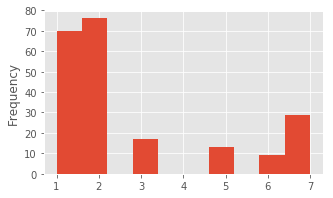

In [249]:
%matplotlib inline

df.glass_type.plot(kind='hist', figsize=(5,3))

In [250]:
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#0F0000', '#005500', 'orange'])

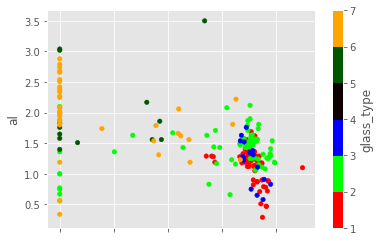

In [251]:
df.plot(kind='scatter', x='mg', y='al', c='glass_type', colormap=cmap_bold)

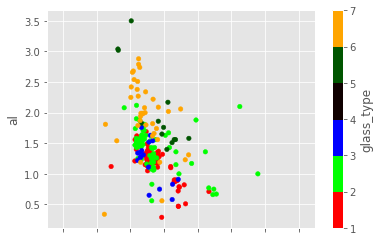

In [252]:
df.plot(kind='scatter', x='ri', y='al', c='glass_type', colormap=cmap_bold)

## TASK 3: convert into binary classification problem 

Convert this into a binary classification problem. Create a new DataFrame column called "binary":
1.	If type of glass = 1/2/3/4, set binary = 0.
2.	If type of glass = 5/6/7, set binary = 1.

In [253]:
df.loc[df['glass_type'] > 4, 'binary'] = 1
df.loc[df['glass_type'] <= 4, 'binary'] = 0

In [254]:
df.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,binary
id,,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,0.0
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,0.0
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,0.0
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,0.0
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,0.0


In [255]:
df.binary.value_counts()

0.0    163
1.0     51
Name: binary, dtype: int64

## TASK 4: create a feature matrix (X) using all features 

In [256]:
from sklearn.neighbors import KNeighborsClassifier

In [257]:
X = df.loc[:, 'ri':'fe']

## TASK 5: create a response vector (y)

In [258]:
y = df.binary

In [259]:
print(X.shape)
print(y.shape)

(214, 9)
(214,)


## TASK 6: split X and y into training and testing set

In [260]:
from sklearn.model_selection import train_test_split

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [262]:
print(X.shape)

print(X_train.shape)
print(X_test.shape)

(214, 9)
(128, 9)
(86, 9)


In [263]:
print(y.shape)

print(y_train.shape)
print(y_test.shape)

(214,)
(128,)
(86,)


In [264]:
X_train

,ri,na,mg,al,si,k,ca,ba,fe
id,,,,,,,,,
81,1.51592,12.86,3.52,2.12,72.66,0.69,7.97,0.00,0.00
21,1.51750,12.82,3.55,1.49,72.75,0.54,8.52,0.00,0.19
75,1.51596,13.02,3.56,1.54,73.11,0.72,7.90,0.00,0.00
143,1.51662,12.85,3.51,1.44,73.01,0.68,8.23,0.06,0.25
183,1.51916,14.15,0.00,2.09,72.74,0.00,10.88,0.00,0.00
66,1.52099,13.69,3.59,1.12,71.96,0.09,9.40,0.00,0.00
181,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.00,0.00
36,1.51567,13.29,3.45,1.21,72.74,0.56,8.57,0.00,0.00
139,1.51674,12.79,3.52,1.54,73.36,0.66,7.90,0.00,0.00


In [265]:
y_train

id
81     0.0
21     0.0
75     0.0
143    0.0
183    1.0
66     0.0
181    1.0
36     0.0
139    0.0
195    1.0
43     0.0
47     0.0
182    1.0
177    1.0
65     0.0
121    0.0
191    1.0
151    0.0
202    1.0
153    0.0
103    0.0
64     0.0
8      0.0
197    1.0
11     0.0
189    1.0
14     0.0
16     0.0
87     0.0
44     0.0
      ... 
167    1.0
150    0.0
22     0.0
199    1.0
1      0.0
132    0.0
53     0.0
127    0.0
39     0.0
45     0.0
179    1.0
165    1.0
209    1.0
58     0.0
212    1.0
56     0.0
95     0.0
110    0.0
104    0.0
59     0.0
138    0.0
51     0.0
201    1.0
88     0.0
105    0.0
130    0.0
198    1.0
184    1.0
175    1.0
123    0.0
Name: binary, Length: 128, dtype: float64

## TASK 7: fit a KNN model on the training set using K=5

In [266]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

## TASK 8: make predictions on the testing set and calculate testing accuracy

In [267]:
from sklearn import metrics

In [268]:
y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9069767441860465

## TASK 9: write a for loop that computes testing accuracy for a range of K values

In [270]:
k_range = range(1, 101)
training_error = []
testing_error = []

In [271]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # training error
    knn.fit(X, y)
    k_fred = knn.predict(X)
    training_error.append(1 - metrics.accuracy_score(y, k_fred))
    
    # testing error
    knn.fit(X_train, y_train)
    k_fred = knn.predict(X_test)
    testing_error.append(1 - metrics.accuracy_score(y_test, k_fred))

## TASK 10: plot K value versus testing accuracy to choose on optimal value for K

In [275]:
k_range

range(1, 101)

Text(0, 0.5, 'Testing Eror')

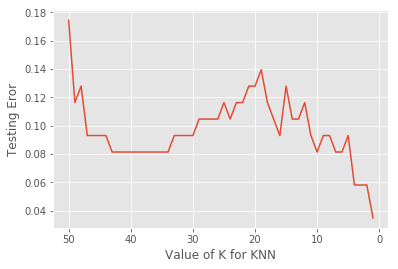

In [276]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(range(1,51), testing_error[:50])
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Eror')

Text(0, 0.5, 'Testing Eror')

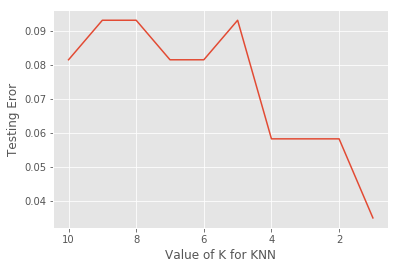

In [277]:
plt.plot(range(1,11), testing_error[:10])
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Eror')

## TASK 11: calculate the null accuracy (see instructions for explanation)

In [278]:
df.binary.value_counts()

0.0    163
1.0     51
Name: binary, dtype: int64

In [279]:
print(df.binary.mean())
print('null accuracy is', max(df.binary.mean(), 1-df.binary.mean()))

0.2383177570093458
null accuracy is 0.7616822429906542


## TASK 12: search for useful features

In [281]:
# redo exercise using only those features
feature_cols = ['mg','ba']
X = df[feature_cols]

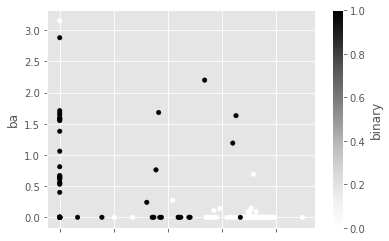

In [282]:
df.plot(kind='scatter', x='mg', y='ba', c='binary')

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [284]:
df.corr()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,binary
ri,1.000000,-0.191885,-0.122274,-0.407326,-0.542052,-0.289833,0.810403,-0.000386,0.143010,-0.164237,-0.134327
na,-0.191885,1.000000,-0.273732,0.156794,-0.069809,-0.266087,-0.275442,0.326603,-0.241346,0.502898,0.452336
mg,-0.122274,-0.273732,1.000000,-0.481799,-0.165927,0.005396,-0.443750,-0.492262,0.083060,-0.744993,-0.758289
al,-0.407326,0.156794,-0.481799,1.000000,-0.005524,0.325958,-0.259592,0.479404,-0.074402,0.598829,0.585928
si,-0.542052,-0.069809,-0.165927,-0.005524,1.000000,-0.193331,-0.208732,-0.102151,-0.094201,0.151565,0.148072
k,-0.289833,-0.266087,0.005396,0.325958,-0.193331,1.000000,-0.317836,-0.042618,-0.007719,-0.010054,0.053774
ca,0.810403,-0.275442,-0.443750,-0.259592,-0.208732,-0.317836,1.000000,-0.112841,0.124968,0.000952,0.040670
ba,-0.000386,0.326603,-0.492262,0.479404,-0.102151,-0.042618,-0.112841,1.000000,-0.058692,0.575161,0.523403
fe,0.143010,-0.241346,0.083060,-0.074402,-0.094201,-0.007719,0.124968,-0.058692,1.000000,-0.188278,-0.194903
glass_type,-0.164237,0.502898,-0.744993,0.598829,0.151565,-0.010054,0.000952,0.575161,-0.188278,1.000000,0.941680


In [286]:
k_range = range(1, 51)
two_feature_training_error = []
two_feature_testing_error = []

In [287]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # training_error
    knn.fit(X, y)
    k_pred = knn.predict(X)
    two_feature_training_error.append(1 - metrics.accuracy_score(y, k_pred))
    
    # testing_error
    knn.fit(X_train, y_train)
    k_pred = knn.predict(X_test)
    two_feature_testing_error.append(1 - metrics.accuracy_score(y_test, k_pred))

Text(0, 0.5, 'Testing Error')

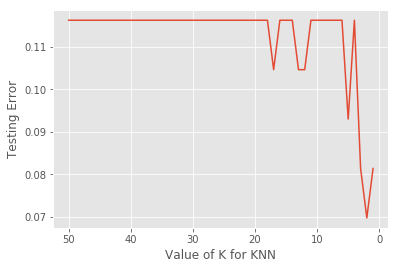

In [288]:
plt.plot(k_range, two_feature_testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

In [289]:
kdf = pd.DataFrame({'K': k_range, 'train':two_feature_training_error, 'test':two_feature_testing_error}).set_index('K').sort_index(ascending=False)
kdf

,train,test
K,,
50,0.121495,0.116279
49,0.116822,0.116279
48,0.116822,0.116279
47,0.116822,0.116279
46,0.116822,0.116279
45,0.116822,0.116279
44,0.116822,0.116279
43,0.116822,0.116279
42,0.116822,0.116279


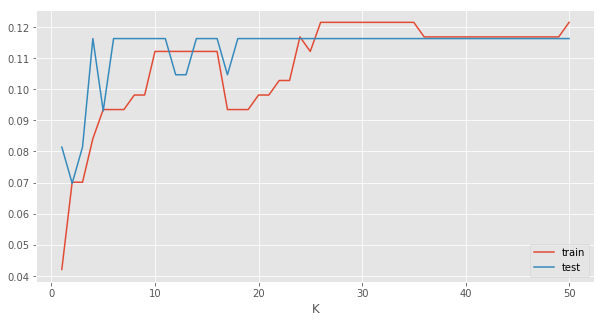

In [290]:
kdf.plot(figsize=(10, 5))

In [226]:
print(X.iloc[1, :])
print(y[1])

mg    3.6
ba    0.0
Name: 2, dtype: float64
0


In [232]:
glass_dimensions = np.array([0, 4])
print(knn.predict_proba(glass_dimensions.reshape(1, -1)))
print(knn.predict(glass_dimensions.reshape(1, -1)))

[[0.4 0.6]]
[1]


## Train on a remote cluster

Now you can expand on this simple model by building a model with a different regularization rate. This time you'll train the model on a remote resource.  

For this task, submit the job to the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create an estimator object
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [233]:
import os
script_folder = './glassification_script'
os.makedirs(script_folder, exist_ok=True)

In [239]:
%%writefile $script_folder/train.py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import azureml
from azureml.core import Workspace, Run
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
df = pd.read_csv(url, names=col_names, index_col='id')

df.loc[df['glass_type'] > 4, 'binary'] = 1
df.loc[df['glass_type'] <= 4, 'binary'] = 0

X = df.loc[:, 'ri':'fe']
y = df.binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

k_range(1, 51)
training_error = []
testing_error = []



Overwriting ./glassification_script/train.py


In [241]:
ws.get_details()

{'id': '/subscriptions/3c3bb71f-3a4c-436f-9e0a-7407d75a82fa/resourceGroups/eml-training/providers/Microsoft.MachineLearningServices/workspaces/eml01-student07',
 'name': 'eml01-student07',
 'location': 'southcentralus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'workspaceid': 'ba5b99e1-5427-44cc-8a97-048ddf657e15',
 'description': '',
 'friendlyName': '',
 'creationTime': '2019-03-10T01:13:31.6571537+00:00',
 'containerRegistry': '/subscriptions/3c3bb71f-3a4c-436f-9e0a-7407d75a82fa/resourcegroups/eml-training/providers/microsoft.containerregistry/registries/eml01student074936631706',
 'keyVault': '/subscriptions/3c3bb71f-3a4c-436f-9e0a-7407d75a82fa/resourcegroups/eml-training/providers/microsoft.keyvault/vaults/eml01student074295838553',
 'applicationInsights': '/subscriptions/3c3bb71f-3a4c-436f-9e0a-7407d75a82fa/resourcegroups/eml-training/providers/microsoft.insights/components/eml01student079800525999',
 'identityPrincipalId': '25fb7fe9-0ccb-4155-a36e-7b20358c9541',


In [243]:
run = exp.start_logging()

In [269]:
run.log('first KNN model(k=5) Accuracy', metrics.accuracy_score(y_test, y_pred))

In [273]:
run.log_list('testing accuracy for K value range(1 to 100)', testing_error)

In [280]:
run.log('null accuracy', max(df.binary.mean(), 1-df.binary.mean()))

In [291]:
run.log_list('two feature testing error', two_feature_testing_error)

In [293]:
run.complete()

In [294]:
print(run.get_portal_url())

https://mlworkspace.azure.ai/portal/subscriptions/3c3bb71f-3a4c-436f-9e0a-7407d75a82fa/resourceGroups/eml-training/providers/Microsoft.MachineLearningServices/workspaces/eml01-student07/experiments/Glassification/runs/84ce6d77-83cf-4f3b-b1e5-a65749fe585a
